<a href="https://colab.research.google.com/github/gunter0128/self-learning/blob/main/CNN-bocchitherock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget
import wget

wget.download("https://github.com/gunter0128/-/raw/main/bocchitherock.zip")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b8af7c88f4703fd682cf38d694e0f360e927592591f5a3a31cbe6f64adb84d3b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'bocchitherock.zip'

In [2]:
import zipfile

with zipfile.ZipFile("bocchitherock.zip", "r") as zip_file:
  zip_file.extractall("bocchitherock")

In [23]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms

class ImageDataset(Dataset):
  def __init__(self, root, train, transform=None):

    if train:
      image_root = Path(root) / "bocchitherock" /"train"
    else:
      image_root = Path(root) / "bocchitherock" / "test"

    with open(Path(root) / "bocchitherock" /"classnames.txt", "r") as f:
      lines = f.readlines()
      self.classes = [line.strip() for line in lines]

    self.paths = [i for i in image_root.rglob("*") if i.is_file()]
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.paths[index]).convert("RGB")
    class_name = self.paths[index].parent.name
    class_idx = self.classes.index(class_name)

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


  def __len__(self):
    return len(self.paths)

In [25]:
train_transforms = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.TrivialAugmentWide(),
  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [26]:
train_dataset = ImageDataset("bocchitherock", train=True, transform=train_transforms)
train_dataset.classes
x, y = train_dataset[0]
x.shape, y

(torch.Size([3, 64, 64]), 2)

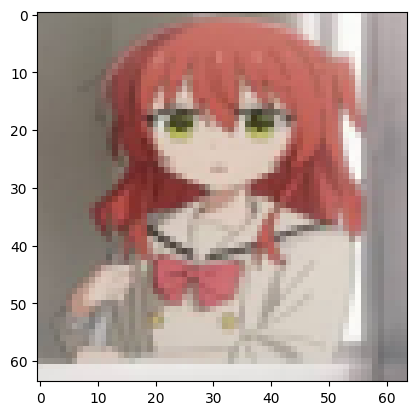

In [50]:
import matplotlib.pyplot as plt

x, y = train_dataset[80]
plt.imshow(x.permute(1, 2, 0))

In [28]:
train_dataset = ImageDataset(root="bocchitherock",
                train=True,
                transform=train_transforms
)

test_dataset = ImageDataset(root="bocchitherock",
                train=False,
                transform=test_transforms
)

In [29]:
len(train_dataset), len(test_dataset)

(120, 40)

In [30]:
from torch.utils.data import DataLoader

BATCH_SIZE = 5

train_dataloader = DataLoader(dataset=train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True
)

test_dataloader = DataLoader(dataset=test_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False
)

In [31]:
len(train_dataloader), len(test_dataloader)

(24, 8)

In [32]:
x_first_batch, y_first_batch = next(iter(train_dataloader))
x_first_batch[0].shape, y_first_batch[0]

(torch.Size([3, 64, 64]), tensor(2))

In [33]:
from torch import nn
class ImageClassificationModel3(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
          out_channels=8,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=8,
          out_channels=8,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2),
            stride=2,
            padding=0
      )
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=8,
          out_channels=16,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=16,
          out_channels=16,
          kernel_size=(3, 3),
          stride=1,
          padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2),
            stride=2,
            padding=0
      )
    )

    self.classifier = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(in_features=16*16*16, out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [34]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
model = ImageClassificationModel3(3, len(train_dataset.classes))
model.to(device)
model(x_first_batch.to(device))

tensor([[ 0.0248, -0.0584, -0.0226,  0.0140],
        [ 0.0257, -0.0620, -0.0184,  0.0125],
        [ 0.0300, -0.0557, -0.0191,  0.0119],
        [ 0.0267, -0.0578, -0.0203,  0.0117],
        [ 0.0257, -0.0558, -0.0236,  0.0169]], grad_fn=<AddmmBackward0>)

In [36]:
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [37]:
def accuracy_fn(y_pred, y_true):

  correct_num = (y_pred==y_true).sum()
  acc = correct_num / len(y_true) * 100

  return acc

In [38]:
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device):
  train_cost = 0
  train_acc = 0
  for batch, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)

    model.train()

    y_pred = model(x)

    cost = cost_fn(y_pred, y)

    train_cost += cost
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

  train_cost /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"\nTrain Cost: {train_cost:.4f}, Train Acc: {train_acc:.2f}")


def test_step(dataloader, model, cost_fn, accuracy_fn, device):
  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)

      test_pred = model(x)

      test_cost += cost_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

    test_cost /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Test Cost: {test_cost:.4f}, Test Acc: {test_acc:.2f} \n")

In [40]:
from tqdm.auto import tqdm

epochs = 20

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model, cost_fn, accuracy_fn, device)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------

Train Cost: 1.0053, Train Acc: 56.67
Test Cost: 0.6915, Test Acc: 82.50 

Epoch: 1
-------

Train Cost: 1.0698, Train Acc: 58.33
Test Cost: 0.5952, Test Acc: 85.00 

Epoch: 2
-------

Train Cost: 0.9582, Train Acc: 66.67
Test Cost: 0.4753, Test Acc: 90.00 

Epoch: 3
-------

Train Cost: 0.8731, Train Acc: 63.33
Test Cost: 0.4549, Test Acc: 87.50 

Epoch: 4
-------

Train Cost: 0.8485, Train Acc: 74.17
Test Cost: 0.4650, Test Acc: 82.50 

Epoch: 5
-------

Train Cost: 0.8550, Train Acc: 60.83
Test Cost: 0.4373, Test Acc: 92.50 

Epoch: 6
-------

Train Cost: 0.6659, Train Acc: 76.67
Test Cost: 0.3515, Test Acc: 85.00 

Epoch: 7
-------

Train Cost: 0.8172, Train Acc: 67.50
Test Cost: 0.4820, Test Acc: 82.50 

Epoch: 8
-------

Train Cost: 0.8449, Train Acc: 71.67
Test Cost: 0.6619, Test Acc: 72.50 

Epoch: 9
-------

Train Cost: 1.0406, Train Acc: 60.00
Test Cost: 0.5400, Test Acc: 87.50 

Epoch: 10
-------

Train Cost: 0.7182, Train Acc: 73.33
Test Cost: 0.3203, Test 

ijichi


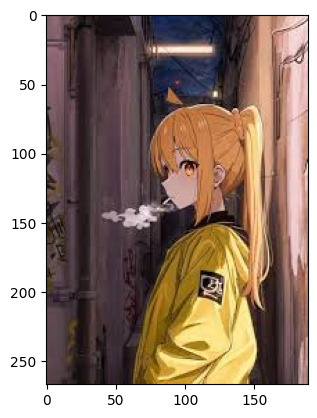

In [51]:
img = Image.open("ijichi.jpg").convert("RGB")
img = test_transforms(img)
img = img.reshape(-1, 3, 64, 64)
img.shape
model.eval()
with torch.inference_mode():
  y_pred = model(img.to(device))
y_pred = torch.softmax(y_pred, dim=1)
class_idx = y_pred.argmax(dim=1)
print(train_dataset.classes[class_idx])
plt.imshow(Image.open("ijichi.jpg").convert("RGB"))

kita


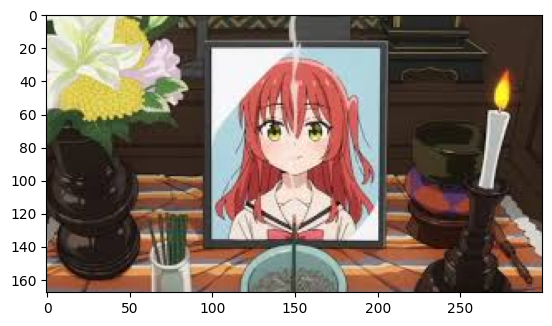

In [52]:
img = Image.open("kita.jpg").convert("RGB")
img = test_transforms(img)
img = img.reshape(-1, 3, 64, 64)
img.shape
model.eval()
with torch.inference_mode():
  y_pred = model(img.to(device))
y_pred = torch.softmax(y_pred, dim=1)
class_idx = y_pred.argmax(dim=1)
print(train_dataset.classes[class_idx])
plt.imshow(Image.open("kita.jpg").convert("RGB"))